In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

In [3]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
from tensorflow.keras.losses import Huber
import pandas as pd
import keras


In [4]:
DATA_DIR = "/content/UTKFace/UTKFace"

# Répartition des âges

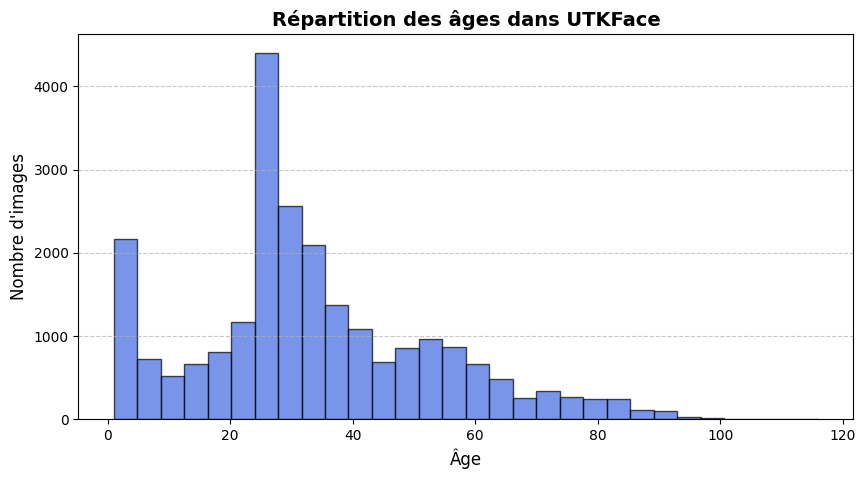

In [5]:
# Extraction des âges depuis le nom des fichiers
ages = []
for filename in os.listdir(DATA_DIR):
    try:
        age = int(filename.split("_")[0])  # Extraction de l'âge (1ère partie du nom de fichier)
        ages.append(age)
    except ValueError:
        pass  # Ignorer les fichiers mal formatés

# Création de l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(ages, bins=30, color="royalblue", edgecolor="black", alpha=0.7)

# Personnalisation du graphique
plt.title("Répartition des âges dans UTKFace", fontsize=14, fontweight="bold")
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Affichage
plt.show()


L'un des principaux défis de ce modèle est la distribution déséquilibrée des âges dans le dataset.

L'histogramme montre une concentration d'images autour de 20 ans, tandis que les extrêmes (0-3 ans et 80+ ans) sont sous-représentés.

Cela risque d'entraîner un biais du modèle en faveur des classes d'âge majoritaires, réduisant ainsi sa capacité à bien généraliser sur les tranches d'âge moins fréquentes.

Ensuite, le choix de la régression pour prédire un âge exact représente un défi supplémentaire. La variabilité de l’âge et la difficulté à obtenir une prédiction précise augmentent le risque d'erreurs élevées (ex. confondre un individu de 30 ans avec un de 50 ans est plus problématique que de prédire 10 ans au lieu de 12).

Enfin, un dernier point à ne pas négliger est la présence de biais dans le dataset, notamment liés au sexe et à l’ethnie, pouvant affecter la capacité du modèle à généraliser sur différentes populations.

# Traitement des images

In [6]:
#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [7]:
def load_data_age(data_dir=DATA_DIR, img_size=(64,64)):
    X = []
    y = []
    file_names = os.listdir(data_dir)

    for file in file_names:
        parts = file.split("_")
        if len(parts) > 1:
            try:
                age = int(parts[0])
            except:
                continue

            img_path = os.path.join(data_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # RGB + Resize + Normalisation
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0

            X.append(img)
            y.append(age)

    return np.array(X), np.array(y)

X, y = load_data_age(DATA_DIR, (IMG_HEIGHT, IMG_WIDTH))
print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape, "Dimension de y :", y.shape)

# Split Train / Val / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de validation :", X_val.shape, len(y_val))
print("Taille du jeu de test :", X_test.shape, len(y_test))


Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3) Dimension de y : (23708,)
Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de validation : (3794, 64, 64, 3) 3794
Taille du jeu de test : (4742, 64, 64, 3) 4742


# Définition des tranches d'âges

In [8]:
# Définition des Tranches d'Âge
age_brackets = [
    (0,3), (4,9), (10,19), (20,29), (30,39),
    (40,49), (50,59), (60,69), (70,79), (80,116)
]

In [9]:
def bracket_index(age):
    for i, (low, high) in enumerate(age_brackets):
        if low <= age <= high:
            return i
    return None

# V1

Dans cette première version ci-dessous, nous adoptons une approche par régression pour prédire l’âge à partir des images, conformément à la consigne : le réseau utilise une seule sortie (Dense(1)) et une loss adaptée (ici Huber, qui est moins sensible aux outliers qu’une MSE classique). En réalité, il s'agit du même modèle utilisé pour la question précédente à quelques excpetions près afin de correspondre aux exigences.

À chaque époque, on surveille la Mean Absolute Error (MAE) pour vérifier la précision moyenne en années. On ajoute également de la data augmentation au début du réseau (flip, rotation, zoom), puis des blocs convolutionnels (16, 32, 64, 128 filtres) avec BatchNormalization et MaxPooling.

Après l’entraînement, on transforme chaque prédiction d’âge en classe (ex. 0–10, 11–20, etc.) afin de mesurer également l’accuracy par tranches, comme demandé.

Pour chaque version du modèle, on affiche des courbes (scatter plot de l’âge réel vs. prédit, histogramme de l’erreur, etc.) afin de visualiser la dispersion des prédictions et diagnostiquer la performance.

In [12]:
# Modèle de la première consigne, adapté pour la régression d'âge

def build_model_age_v1(input_shape=(64,64,3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie régression => 1 neurone (pas de sigmoid)
        Dense(1)
    ])

    # Compilation : Huber comme loss, et on surveille la MAE
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(),
        metrics=['mae']
    )
    return model

model_v1 = build_model_age_v1((IMG_HEIGHT, IMG_WIDTH, 3))
model_v1.summary()


# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

In [15]:
# Entraînement

history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 117s 246ms/step - loss: 9.3980 - mae: 9.8853 - val_loss: 8.7227 - val_mae: 9.2102 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 112s 237ms/step - loss: 9.0250 - mae: 9.5119 - val_loss: 8.5413 - val_mae: 9.0248 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 139s 293ms/step - loss: 8.6375 - mae: 9.1236 - val_loss: 9.4656 - val_mae: 9.9539 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 228ms/step - loss: 8.4198 - mae: 8.9046 - val_loss: 8.3268 - val_mae: 8.8122 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 148s 240ms/step - loss: 8.5140 - mae: 8.9990 - val_loss: 9.9742 - val_mae: 10.4622 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 235ms/step - loss: 8.2505 - mae: 8.7366 - val_loss: 6.9971 - val_mae: 7.4780 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 225ms/step - loss: 8.3124 - mae: 8.7971 - val_loss: 7.0737 - val_mae: 7.5556 -

[V1] Test Loss (Huber): 5.9401
[V1] Test MAE         : 6.4189


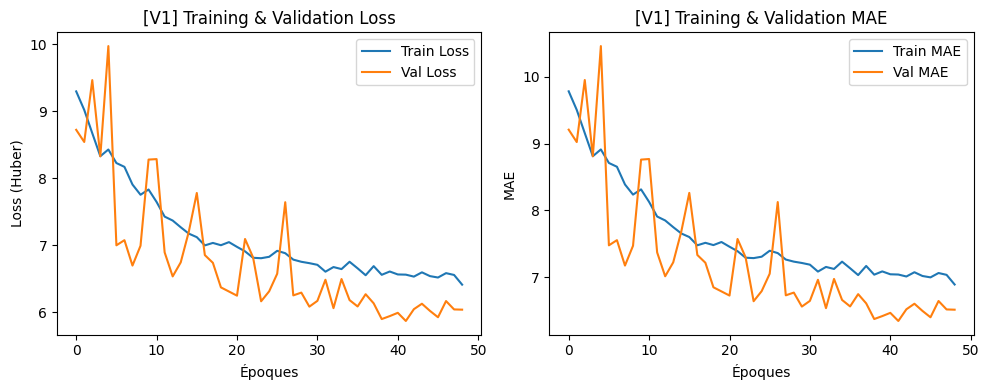

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step


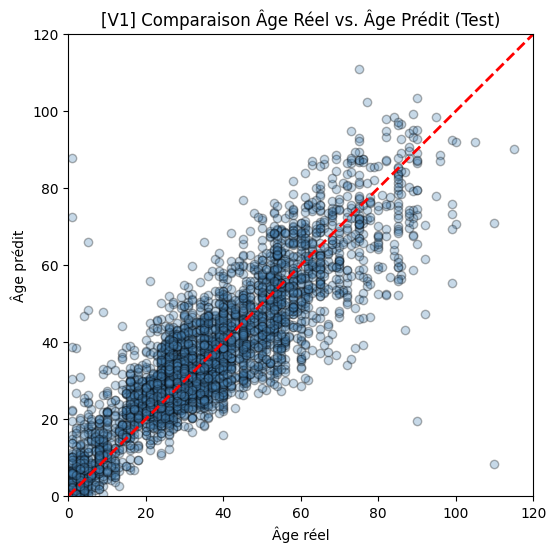

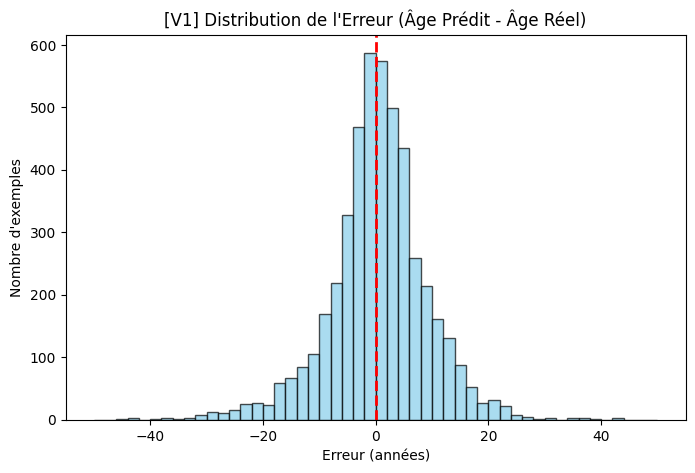

[V1] Accuracy (classes d’âge) : 0.4725747472574747
[V1] Classification report sur les tranches d'âge :
              precision    recall  f1-score   support

           0       0.83      0.53      0.64       317
           1       0.38      0.38      0.38       239
           2       0.35      0.33      0.34       294
           3       0.66      0.65      0.65      1453
           4       0.38      0.46      0.42       885
           5       0.31      0.38      0.34       466
           6       0.41      0.32      0.36       476
           7       0.31      0.31      0.31       251
           8       0.28      0.28      0.28       143
           9       0.51      0.38      0.44       125

    accuracy                           0.47      4649
   macro avg       0.44      0.40      0.42      4649
weighted avg       0.49      0.47      0.48      4649



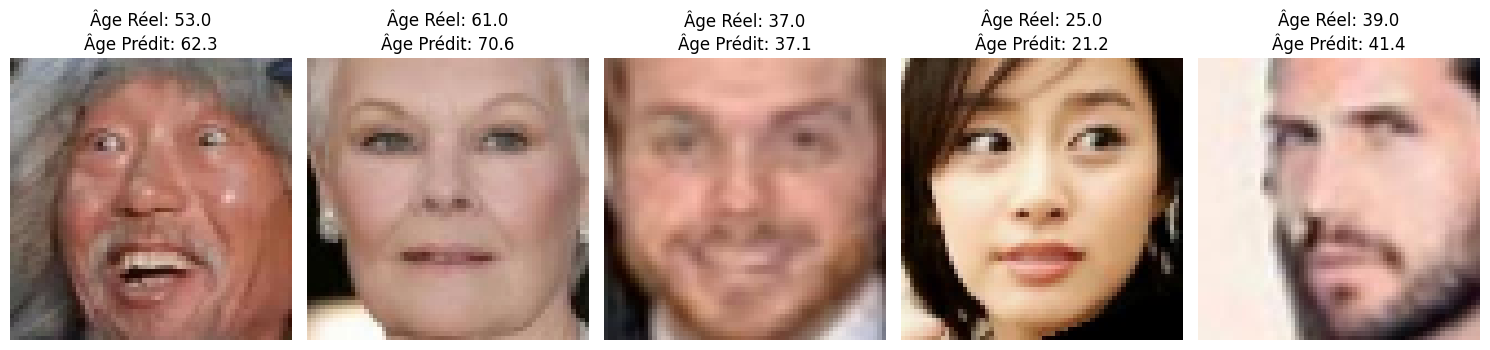

In [16]:
# Évaluation du modèle sur l'ensemble de test
test_loss_v1, test_mae_v1 = model_v1.evaluate(X_test, y_test, verbose=0)
print(f"[V1] Test Loss (Huber): {test_loss_v1:.4f}")
print(f"[V1] Test MAE         : {test_mae_v1:.4f}")

plt.figure(figsize=(10,4))

# Courbe de la Loss (Erreur Huber)
plt.subplot(1,2,1)
plt.plot(history_v1.history['loss'], label='Train Loss')       # Erreur sur les données d'entraînement
plt.plot(history_v1.history['val_loss'], label='Val Loss')     # Erreur sur les données de validation
plt.xlabel('Époques')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.title('[V1] Training & Validation Loss')

# Courbe de la MAE (Erreur Moyenne Absolue)
plt.subplot(1,2,2)
plt.plot(history_v1.history['mae'], label='Train MAE')         # MAE sur les données d'entraînement
plt.plot(history_v1.history['val_mae'], label='Val MAE')       # MAE sur les données de validation
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.title('[V1] Training & Validation MAE')

plt.tight_layout()  # Ajuste automatiquement l'espacement des subplots
plt.show()


# Prédiction des âges pour l'ensemble de test
y_pred_v1 = model_v1.predict(X_test).flatten()

# Graphique en nuage de points
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_v1, alpha=0.3, color='steelblue', edgecolor='k')  # Points des prédictions
plt.plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale
plt.xlabel("Âge réel")
plt.ylabel("Âge prédit")
plt.title("[V1] Comparaison Âge Réel vs. Âge Prédit (Test)")
plt.xlim([0,120])
plt.ylim([0,120])
plt.show()

# Calcul de l'erreur de prédiction (différence entre âge prédit et âge réel)
errors_v1 = y_pred_v1 - y_test

# Histogramme de la distribution des erreurs
plt.figure(figsize=(8,5))
plt.hist(errors_v1, bins=50, range=(-50,50), alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2)  # Ligne rouge à zéro (aucune erreur)
plt.title("[V1] Distribution de l'Erreur (Âge Prédit - Âge Réel)")
plt.xlabel("Erreur (années)")
plt.ylabel("Nombre d'exemples")
plt.show()

# Conversion des âges prédits en catégories
y_pred_brackets_v1 = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v1]

# Conversion des âges réels en catégories
y_test_brackets_v1 = [bracket_index(int(age_true)) for age_true in y_test]

# Suppression des valeurs None (âges hors tranches définies)
valid_idx_v1 = [i for i, br in enumerate(y_pred_brackets_v1) if br is not None]
y_pred_brackets_v1_valid = [y_pred_brackets_v1[i] for i in valid_idx_v1]
y_test_brackets_v1_valid = [y_test_brackets_v1[i] for i in valid_idx_v1]

# Conversion en numpy array pour calcul des métriques
y_pred_brackets_v1_valid = np.array(y_pred_brackets_v1_valid, dtype=int)
y_test_brackets_v1_valid = np.array(y_test_brackets_v1_valid, dtype=int)

# Calcul de l'accuracy en classification par tranches d'âge
acc_brackets_v1 = accuracy_score(y_test_brackets_v1_valid, y_pred_brackets_v1_valid)
print("[V1] Accuracy (classes d’âge) :", acc_brackets_v1)

# Rapport de classification détaillé
print("[V1] Classification report sur les tranches d'âge :")
print(classification_report(y_test_brackets_v1_valid, y_pred_brackets_v1_valid))


def visualize_predictions_v1(X, y_true, y_pred, n=5):
    """
    Affiche n images avec l'âge réel et l'âge prédit.
    """
    import random
    indices = random.sample(range(len(X)), n)  # Sélection aléatoire d'images
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i+1)
        img = X[idx]  # Image correspondante
        plt.imshow(img)
        real_age = y_true[idx]  # Âge réel
        pred_age = y_pred[idx]  # Âge prédit
        ax.set_title(f"Âge Réel: {real_age:.1f}\nÂge Prédit: {pred_age:.1f}")
        ax.axis('off')  # Supprime les axes

    plt.tight_layout()
    plt.show()

# Affichage de quelques exemples prédits
visualize_predictions_v1(X_test, y_test, y_pred_v1, n=5)


Courbes d’Apprentissage

Sur les deux graphes, on voit d’abord une chute rapide de la perte (loss) et de la MAE pendant les premières époques, puis une stabilisation plus progressive.
La val_loss (et val_mae) descend également au fil des itérations, présentant parfois des fluctuations (pics). Globalement, le réseau apprend et ne montre pas de surapprentissage excessif (pas d’explosion de la validation).
Test Loss (Huber) ~5.94 et Test MAE ~6.42

Avec ~6.4 ans d’erreur moyenne, le réseau se trompe en moyenne de 6 ans sur l’âge. C’est un résultat convenable pour un entraînement from scratch sur UTKFace, compte tenu de la répartition très inégale des âges (beaucoup de visages jeunes).
On pourrait descendre plus bas (4–5 ans d’erreur) en utilisant par exemple un modèle pré-entraîné (Transfer Learning dans le modèle 3 de la SAE) ou plus de données pour les âges extrêmes.


Scatter Plot (Âge Réel vs. Âge Prédit)

La majorité des points s’alignent globalement près de la diagonale. Plus l’âge est élevé (60–100), plus on observe une dispersion.
Cela reflète la pénurie d’exemples dans les classes seniors, d’où la difficulté de généraliser correctement pour ces tranches.

Histogramme de l’Erreur

Il est centrée autour de 0, avec la majorité des écarts entre -15 et +15 ans.
Le pic au milieu indique que le réseau prédit souvent proche de l’âge réel. Les extrêmes (±30–40 ans) sont rares, correspondant généralement aux âges très minoritaires dans UTKFace.

Classification par Tranches (Accuracy ~47 %)

Avec ces tranches d'âges, on obtient ~47 % de bonnes tranches. Cela veut dire que sur 10 classes définies, près de la moitié des images tombent dans la bonne plage d’âge.

Les tranches dominantes (ex. 20–29) affichent généralement une précision/rappel plus élevés, alors que les classes plus rares (ex. 5–9, 60–69) peuvent avoir des f1-scores plus modestes, faute d’exemples nombreux.

# V2

In [17]:
# Modèle de la première consigne, adapté pour la régression d'âge

def build_model_age_v2(input_shape=(64,64,3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),


        # Bloc 5
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie régression => 1 neurone (pas de sigmoid)
        Dense(1)
    ])

    # Compilation : Huber comme loss, et on surveille la MAE
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(),
        metrics=['mae']
    )
    return model

model_v2 = build_model_age_v1((IMG_HEIGHT, IMG_WIDTH, 3))
model_v2.summary()


# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

In [18]:
history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 115s 233ms/step - loss: 28.8108 - mae: 29.3069 - val_loss: 19.1401 - val_mae: 19.6352 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 138s 223ms/step - loss: 10.8167 - mae: 11.3050 - val_loss: 8.7817 - val_mae: 9.2685 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 146s 232ms/step - loss: 9.6734 - mae: 10.1609 - val_loss: 11.9983 - val_mae: 12.4888 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - loss: 9.2272 - mae: 9.7137 - val_loss: 7.7917 - val_mae: 8.2762 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 110s 232ms/step - loss: 8.5614 - mae: 9.0482 - val_loss: 10.3922 - val_mae: 10.8828 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 222ms/step - loss: 8.4288 - mae: 8.9156 - val_loss: 7.2225 - val_mae: 7.7051 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - loss: 8.1275 - mae: 8.6132 - val_loss: 10.8796 - val_ma

[V2] Test Loss (Huber): 5.9698
[V2] Test MAE         : 6.4501


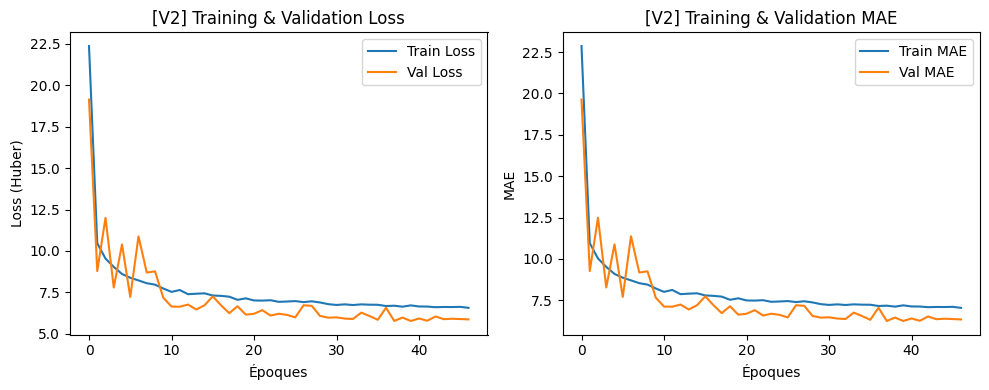

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step


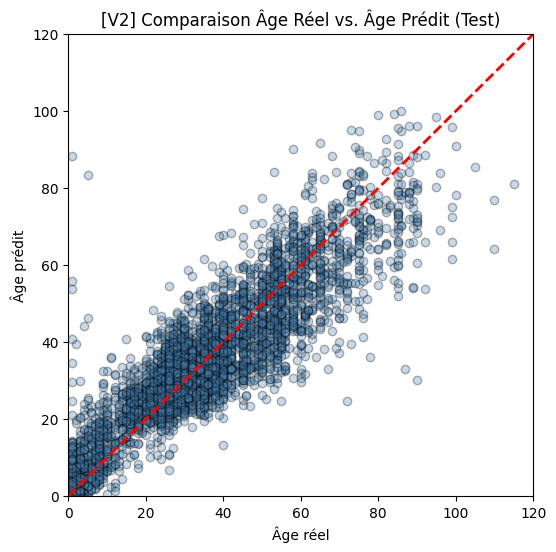

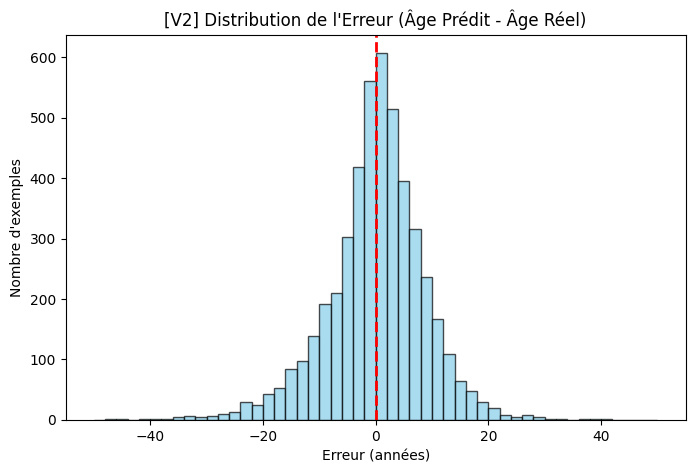

[V2] Accuracy (classes d’âge) : 0.4655730628102741
[V2] Classification report sur les tranches d'âge :
              precision    recall  f1-score   support

           0       0.79      0.46      0.58       304
           1       0.39      0.35      0.37       237
           2       0.35      0.33      0.34       294
           3       0.65      0.65      0.65      1453
           4       0.38      0.48      0.42       885
           5       0.28      0.35      0.31       466
           6       0.41      0.33      0.36       476
           7       0.34      0.32      0.33       250
           8       0.28      0.24      0.26       143
           9       0.52      0.29      0.37       125

    accuracy                           0.47      4633
   macro avg       0.44      0.38      0.40      4633
weighted avg       0.48      0.47      0.47      4633



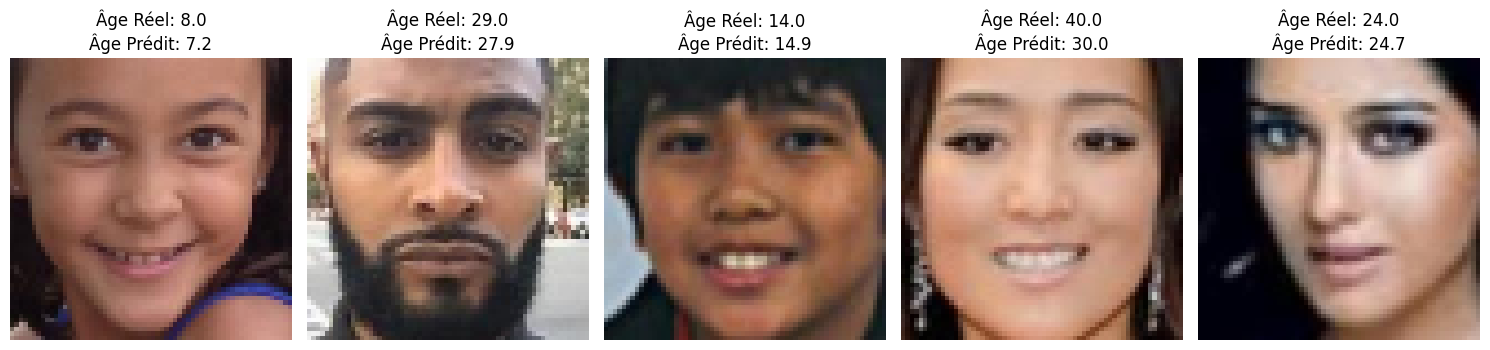

In [19]:
 # Évaluation du modèle sur l'ensemble de test

test_loss_v2, test_mae_v2 = model_v2.evaluate(X_test, y_test, verbose=0)
print(f"[V2] Test Loss (Huber): {test_loss_v2:.4f}")
print(f"[V2] Test MAE         : {test_mae_v2:.4f}")

plt.figure(figsize=(10,4))

# Courbe de la Loss (Erreur Huber)
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], label='Train Loss')       # Erreur sur entraînement
plt.plot(history_v2.history['val_loss'], label='Val Loss')     # Erreur sur validation
plt.xlabel('Époques')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.title('[V2] Training & Validation Loss')

# Courbe de la MAE (Erreur Absolue Moyenne)
plt.subplot(1,2,2)
plt.plot(history_v2.history['mae'], label='Train MAE')         # MAE entraînement
plt.plot(history_v2.history['val_mae'], label='Val MAE')       # MAE validation
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.title('[V2] Training & Validation MAE')

plt.tight_layout()
plt.show()


# Prédiction des âges sur le jeu de test

y_pred_v2 = model_v2.predict(X_test).flatten()

# Graphique en nuage de points (réel vs prédit)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_v2, alpha=0.3, color='steelblue', edgecolor='k')
plt.plot([0,120],[0,120], color='red', linestyle='--', linewidth=2)  # Diagonale
plt.xlabel("Âge réel")
plt.ylabel("Âge prédit")
plt.title("[V2] Comparaison Âge Réel vs. Âge Prédit (Test)")
plt.xlim([0,120])
plt.ylim([0,120])
plt.show()

# Calcul de l'erreur (différence entre âge prédit et âge réel)
errors_v2 = y_pred_v2 - y_test

# Histogramme de la distribution des erreurs
plt.figure(figsize=(8,5))
plt.hist(errors_v2, bins=50, range=(-50,50), alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title("[V2] Distribution de l'Erreur (Âge Prédit - Âge Réel)")
plt.xlabel("Erreur (années)")
plt.ylabel("Nombre d'exemples")
plt.show()


# Conversion des âges prédits en catégories (brackets)

y_pred_brackets_v2 = [bracket_index(int(round(age_pred))) for age_pred in y_pred_v2]
y_test_brackets_v2 = [bracket_index(int(age_true)) for age_true in y_test]

# Suppression des None (hors tranches définies)
valid_idx_v2 = [i for i, br in enumerate(y_pred_brackets_v2) if br is not None]
y_pred_brackets_v2_valid = [y_pred_brackets_v2[i] for i in valid_idx_v2]
y_test_brackets_v2_valid = [y_test_brackets_v2[i] for i in valid_idx_v2]

y_pred_brackets_v2_valid = np.array(y_pred_brackets_v2_valid, dtype=int)
y_test_brackets_v2_valid = np.array(y_test_brackets_v2_valid, dtype=int)

# Calcul de l'accuracy en classification par tranches d'âge
acc_brackets_v2 = accuracy_score(y_test_brackets_v2_valid, y_pred_brackets_v2_valid)
print("[V2] Accuracy (classes d’âge) :", acc_brackets_v2)

# Rapport de classification détaillé
print("[V2] Classification report sur les tranches d'âge :")
print(classification_report(y_test_brackets_v2_valid, y_pred_brackets_v2_valid))


# Visualiser quelques prédictions

def visualize_predictions_v2(X, y_true, y_pred, n=5):
    """
    Affiche n images avec l'âge réel et l'âge prédit (V2).
    """
    import random
    indices = random.sample(range(len(X)), n)
    plt.figure(figsize=(15, 3*n))

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i+1)
        img = X[idx]
        plt.imshow(img)
        real_age = y_true[idx]
        pred_age = y_pred[idx]
        ax.set_title(f"Âge Réel: {real_age:.1f}\nÂge Prédit: {pred_age:.1f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions_v2(X_test, y_test, y_pred_v2, n=5)


Le modèle V2 possède une couche de convolution supplémentaire (256 filtres) par rapport au V1, ce qui lui confère a priori une plus grande capacité d’apprentissage. Néanmoins, les résultats finaux (MAE ~6 ans, accuracy par tranches autour de 46–47 %) restent très proches de ceux obtenus avec le V1. Autrement dit, l’ajout d’un bloc convolutionnel supplémentaire n’a pas sensiblement amélioré la performance, probablement à cause de la distribution inégale du dataset

Le train_loss et la val_loss chutent fortement au début, puis se stabilisent vers une MSE (ou Huber) ~6–7 après une quarantaine d’époques.
Les courbes ne montrent pas de surapprentissage majeur : la validation suit plutôt bien la courbe d’entraînement.


Le réseau se trompe donc d’environ 6–7 ans sur l’ensemble du test, ce qui est conforme à d’autres approches from scratch sur UTKFace.
Les âges extrêmes (enfants, personnes âgées) restent difficiles à prédire précisément faute de nombreux exemples.


Les points sont globalement alignés sur la diagonale, signe que le modèle apprend une bonne corrélation entre l’image et l’âge.
À mesure qu’on monte au‐delà de 60–70 ans, la dispersion augmente, reflétant la pénurie de données dans ces tranches

Pour les classes, près de la moitié des prédictions tombent dans la bonne tranche.
Les tranches majoritaires (ex. 20–29) affichent une meilleure f1‐score que les classes rares, logique vu la distribution réelle.


En résumé, le V2 montre une performance quasi identique à celle du V1, démontrant que l’ajout d’une couche convolutionnelle ne résout pas, à lui seul, la difficulté de la répartition d’UTKFace. Pour des gains plus substantiels, il conviendrait d’envisager un réseau pré‐entraîné, un suréchantillonnage plus marqué pour les âges sous‐représentés ou une data augmentation plus ciblée sur ces tranches rares.